In [17]:
#Libraries to import.
%pylab inline
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)


from patch_fn import return_valid_and_random_pts, register
from patch_fn import make_figure, drift_corr, collate_data,calculate_measurements
import find_maxima_fn as maxima

import scipy
from os import listdir
from os.path import isfile, join
from scipy import signal
from scipy.ndimage import interpolation
import copy
from scipy.ndimage import filters
from scipy import ndimage

import csv
import numpy as np
import tifffile
import json
from sklearn.preprocessing import scale
import cPickle as pickle


Populating the interactive namespace from numpy and matplotlib


processing 00_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr
drift correction: pixel shift in x: 2.0
drift correction: pixel shift in y: 2.0
processing 01_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr
drift correction: pixel shift in x: 5.0
drift correction: pixel shift in y: 5.0
processing 03_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr
drift correction: pixel shift in x: 1.0
drift correction: pixel shift in y: 1.0


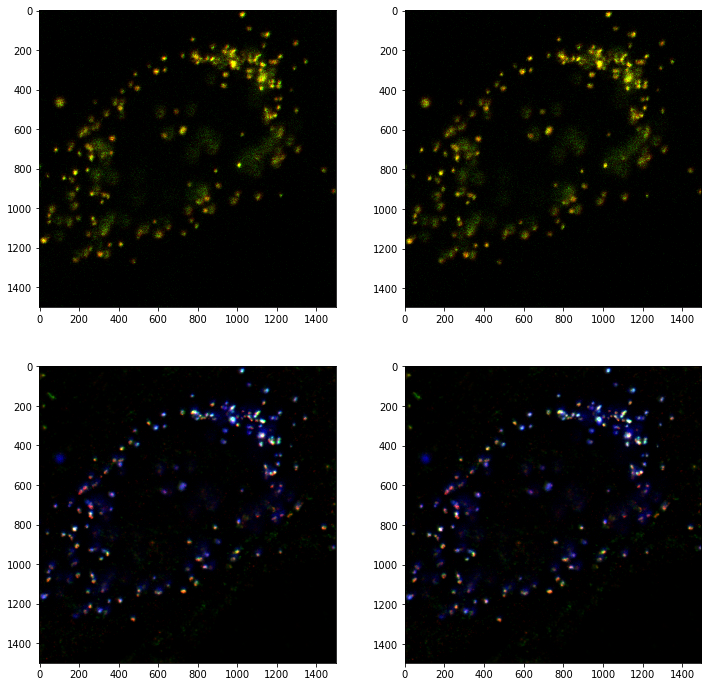

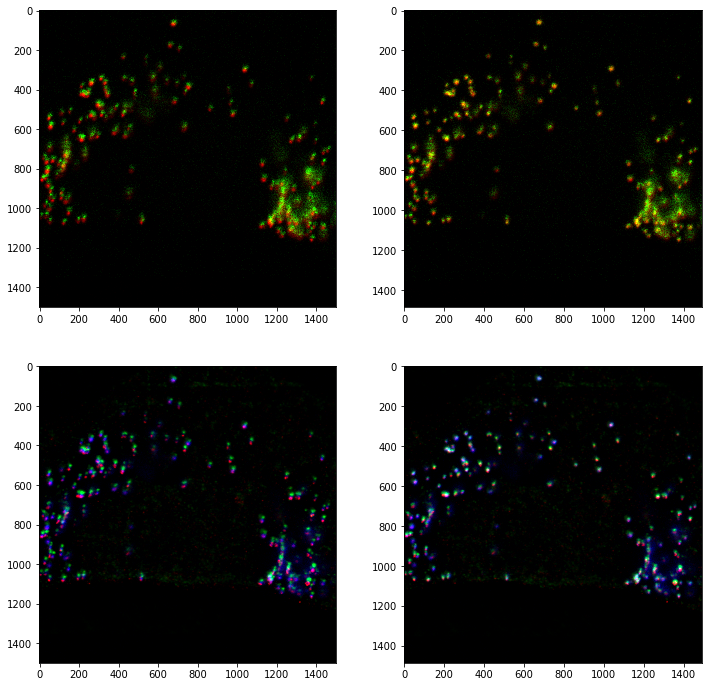

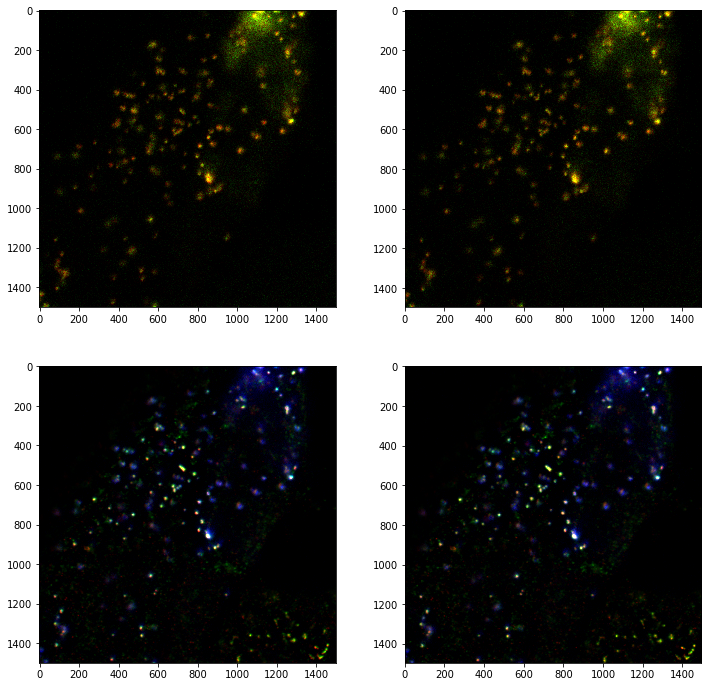

In [18]:
#This is the code for correcting the two colour STED with confocal gfp signal (4 image channels).
#First it corrects the code by 

folderlist =[]
#This is where you add all the folders that your want to search through on your computer"""
folderlist.append('pex/double_pex_CH_new/originals/');

corr_x = 1 ;#The STED to confocal pixel correction in the x-dimension.
corr_y = -2;#The STED to confocal pixel correction in the y-dimension.
diameter_of_roi = 20; #Diameter of the ROI.
noi_tol = 10 #Noise tolerance for the maxima detection.

#output for corrected and registered images
output_path = 'pex/RGB_im/'

data_store ={}

for path in folderlist:
    
    
    filelist = [ f for f in listdir(path) if isfile(join(path,f)) ]
            
    for filename in filelist:
        
        if filename[:3] == '.DS':
            continue;
        
        if filename[-4:] != '.msr':
            continue
        
        print 'processing',filename
        im0raw = bioformats.load_image(path+filename, series=0) #confocal 
        im1raw = bioformats.load_image(path+filename, series=1) #sted APD2
        im2raw = bioformats.load_image(path+filename, series=2) #confocal
        im3raw = bioformats.load_image(path+filename, series=3) #sted APD3
            
        assert im0raw.shape == im1raw.shape == im2raw.shape == im3raw.shape, "Your images are not the same size"
        
        
        data_store[filename] = {}
        
        
        #This is just for comparison. This is the command which corrects confocal to STED detection channels.
        im0_after, im1_after, im2_after, im3_after = register(im0raw,im1raw,im2raw,im3raw,0,0)
        #Makes the raw figure with just the registration correction.
        imRGBB,imRGBA = make_figure(im0raw.astype(np.float64),im1raw.astype(np.float64),im2raw.astype(np.float64),im3raw.astype(np.float64))
        
        #Makes the drift corrected. Moves red relative to green. -ve is left and up.
        #The last two numbers define the confocal channel to STED offset. This is supplied by Silvia.
        im0_after, im1_after,im2_after, im3_after = drift_corr(im0_after,im1_after,im2_after,im3_after,corr_x,corr_y)
        #Makes figure with the registration between red and green channel
        imRGB2,imRGB1 = make_figure(im0_after,im1_after,im2_after,im3_after)
        
        
        output = np.zeros((4,im0_after.shape[0],im0_after.shape[1])).astype(np.float32)
        output[0,:,:] = im0_after
        output[1,:,:] = im1_after
        output[2,:,:] = im2_after
        output[3,:,:] = im3_after
        output = output*65535
        
        data_store[filename]['img_corr'] = output
        #plotting.
        figsize(12,12)
        figure()
        subplot(2,2,1)
        imshow(imRGBA)
        subplot(2,2,2)
        imshow(imRGB1)
        subplot(2,2,3)
        imshow(imRGBB)
        subplot(2,2,4)
        imshow(imRGB2)
        #savefig('pex/20150415 3 colori Perox/con_output_CorrFull2/fig'+filename, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None)
        metadata = dict(microscope='Abberior', shape=output.shape, dtype=output.dtype.str)
        metadata = json.dumps(metadata)
        tifffile.imsave(output_path+filename.split('.msr')[:-1][0]+'.tiff', output)
        
        
        
        
        img = ndimage.filters.gaussian_filter(output[0,:,:], 2.0)
        ypts, xpts = maxima.find_maxima(noi_tol, img)
        height, width = img.shape
        
        o_xpts, o_ypts, rn_xpts, rn_ypts = return_valid_and_random_pts(xpts, ypts,diameter_of_roi,height, width)
        
        data_store[filename]['height'] = height
        data_store[filename]['width'] = width        
        data_store[filename]['o_xpts'] = o_xpts
        data_store[filename]['o_ypts'] = o_ypts
        data_store[filename]['rn_xpts'] = rn_xpts
        data_store[filename]['rn_ypts'] = rn_ypts

In [7]:
#Saves out the corrected data as a pickle file. So can come back to it.
output_data_path = 'pex/output_data/'
for file_name in data_store:
    pickle.dump(data_store[file_name], open( output_data+file_name[:-4]+".p", "wb" ) )

In [3]:
#Loads in corrected data from a pickle file.
output_data_path = 'pex/output_data/' #should be same as above.
filelist = [ f for f in listdir(output_data_path) if isfile(join(output_data_path,f)) ]
data_store = {}
for filename in filelist:
    data_store[filename[:-2]+'.msr'] = pickle.load( open(  output_data_path+filename, "rb" ) )
    

00_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr
03_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr
01_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr


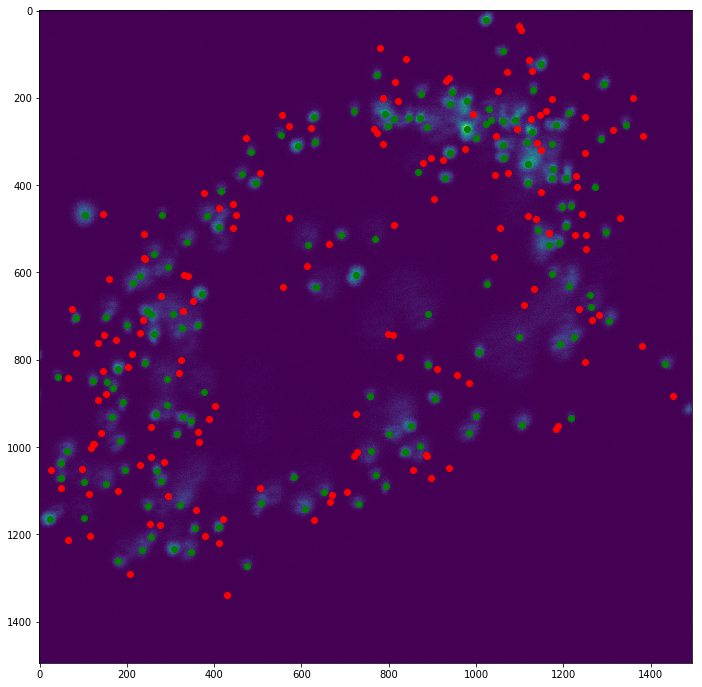

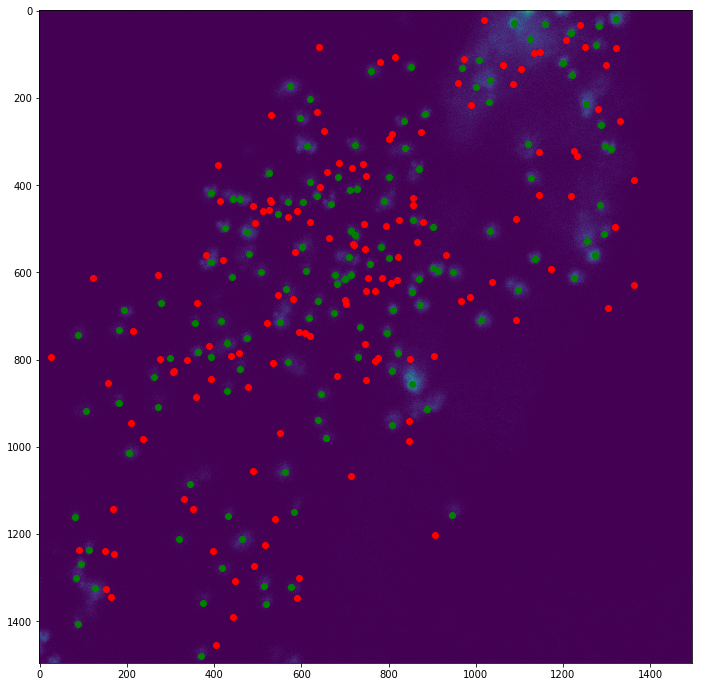

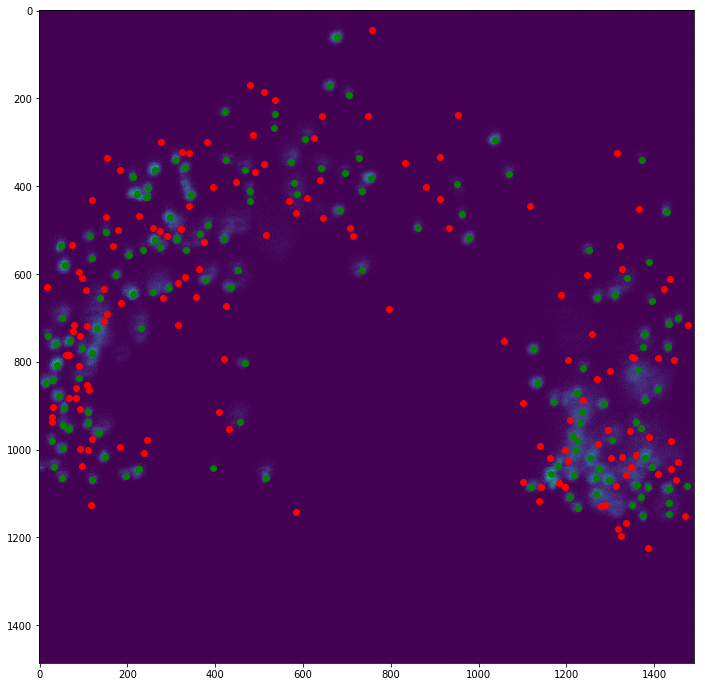

In [19]:
for filename in data_store:
    print filename
    figsize(12,12)
    figure()
    #Plot the peroxisome points (green)
    plot(data_store[filename]['o_xpts'],data_store[filename]['o_ypts'],'go')
    #Plot the random locations (red)
    plot(data_store[filename]['rn_xpts'],data_store[filename]['rn_ypts'],'ro')
    #Overlay points onto the image.
    imshow(data_store[filename]['img_corr'][0,:,:])


In [212]:
import patch_fn as pf
reload(pf)
#Makes measurements for each cell and updates data_store
diameter_of_roi = 20
data_store = pf.calculate_measurements(data_store,diameter_of_roi,False) #for regions near perox.
data_store = pf.calculate_measurements(data_store,diameter_of_roi,True) #for random regions.
#Current measurements being made/calculated:
#ch0_ave          - mean intensity from regions in channel 0.
#ch1_ave          - mean intensity from regions in channel 1.
#ch2_ave          - mean intensity from regions in channel 2.
#ch3_ave          - mean intensity from regions in channel 3.
#rand_ch0_ave     - mean intensity from random regions in channel 0.
#rand_ch1_ave     - mean intensity from random regions in channel 1.
#rand_ch2_ave     - mean intensity from random regions in channel 2.
#rand_ch3_ave     - mean intensity from random regions in channel 3.
#ch0_sum          - integrated intensity from regions in channel 0.
#ch1_sum          - integrated intensity from regions in channel 1.
#ch2_sum          - integrated intensity from regions in channel 2.
#ch3_sum          - integrated intensity from regions in channel 3.
#rand_ch0_sum     - integrated intensity from random regions in channel 0.
#rand_ch1_sum     - integrated intensity from random regions in channel 1.
#rand_ch2_sum     - integrated intensity from random regions in channel 2.
#rand_ch3_sum     - integrated intensity from random regions in channel 3.
#ch0_ave_norm     - mean intensity from regions in channel 0 normalised to max for each cell.
#ch1_ave_norm     - mean intensity from regions in channel 1 normalised to max for each cell.
#ch2_ave_norm     - mean intensity from regions in channel 2 normalised to max for each cell.
#ch3_ave_norm     - mean intensity from regions in channel 3 normalised to max for each cell.
#rand_ch0_ave_norm     - mean intensity from random regions in channel 0 normalised to max for each cell.
#rand_ch1_ave_norm     - mean intensity from random regions in channel 1 normalised to max for each cell.
#rand_ch2_ave_norm     - mean intensity from random regions in channel 2 normalised to max for each cell.
#rand_ch3_ave_norm     - mean intensity from random regions in channel 3 normalised to max for each cell.
#rand_ch13_pea         - Pearson's correlation from random regions in channel 1 compared to channel 3.
#rand_ch13_pea_flip    - Pearson's correlation from random regions in channel 1 compared to channel 3 flipped left to right.

patch_fn.py:147: RuntimeWarning: divide by zero encountered in long_scalars
  ch13_pea  = np.sum((np.array(cir_reg1)-np.average(cir_reg1))*(np.array(cir_reg3)-np.average(cir_reg3)))
patch_fn.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  sq_reg2 = ch2[yp-radius:yp+radius+1,xp-radius:xp+radius+1]
patch_fn.py:131: RuntimeWarning: divide by zero encountered in long_scalars
  sq_reg3 = ch3[yp-radius:yp+radius+1,xp-radius:xp+radius+1]
patch_fn.py:99: RuntimeWarning: divide by zero encountered in long_scalars
  sq_reg1 = ch1[yp-radius:yp+radius+1,xp-radius:xp+radius+1]


processing 00_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr
processing 03_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr
processing 01_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr
processing 00_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr
processing 03_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr
processing 01_Sample1_kk114_Pex5_APD2_STED2V_px20nm_ab600_Pex14_APD3_STED3V_px20nm.msr


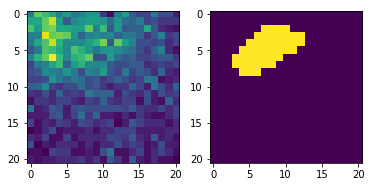

In [213]:
for ds in data_store:
    subplot(1,2,1)
    imshow(data_store[ds]['ch3_raw'][14])
    subplot(1,2,2)
    imshow(data_store[ds]['ch3_erd'][14])

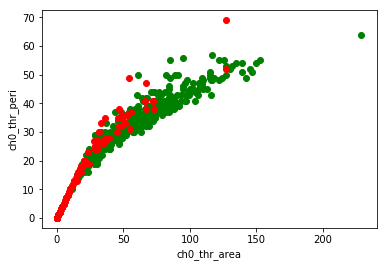

In [214]:

#Example of analysis.
#Comparing Ch1 and Ch3 in the regions close to peroxisome staining
#to Ch1 and Ch3 in regions away from peroxisome staining.

#Collates the measurements for each file and displays them
condition_x = 'ch0_thr_area'
condition_y = 'ch0_thr_peri'

xlabel(condition_x)
ylabel(condition_y)
 
values_x,values_y = collate_data(data_store,condition_x,condition_y)
plot(values_x,values_y,'go')

#Collates the measurements for each file and displays them
condition_x = 'rand_ch0_thr_area'
condition_y = 'rand_ch0_thr_peri'
 
values_x,values_y = collate_data(data_store,condition_x,condition_y)
plot(values_x,values_y,'ro')


In [165]:
tifffile.imsave( 'save.tiff',data_store[ds]['ch3_raw'][14])

In [150]:
from PIL import Image
import numpy as np
%pylab inline
import patch_fn as pf
reload(pf)
img = np.array(Image.open('pex/RGB_im/lena-std.png'))
print pf.renyientropy(img)

Populating the interactive namespace from numpy and matplotlib
125.681357384
